##Setup & Dataset Import

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# import MNIST
train_data = datasets.MNIST(
    root = './data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = './data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 236899989.43it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35357762.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65752287.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19088706.18it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Dataloader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f129b676500>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f129b675240>}

## Construct Negative Examples for Unsupervised Training



In [5]:
filter = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]])

def blur(img,filter):
  # blur img using filter
  # params: filter --> torch.tensor(2*radius+1,2*radius+1)
  m,n = img.shape
  radius = (filter.shape[0]-1)//2
  new_img = torch.zeros(m,n)
  for i in range(m):
    for j in range(n):
      top,left,bottom,right = max(0,i-radius),max(0,j-radius),min(m-1,i+radius),min(m-1,j+radius)
      new_img[i][j] = sum([img[x][y]*filter[x-i+radius][y-j+radius]
                           for y in range(left,right+1) for x in range(top,bottom+1)])
  return new_img

def generate_negative_example():
  # construct a negative example for unsupervised case (3.2 in paper)
  mask = (torch.rand(28,28) > 0.5).long() # initiate as random bit image

  for i in range(6): # repeat blurring 6 times
    mask = blur(mask,filter)

  mask = (mask > 0.5).long() # mask

  index1,index2 = torch.randint(len(train_data),(2,))
  return (mask * train_data[index1][0] + (1-mask) * train_data[index2][0])

## Model Definition



In [6]:
# single-layer NN
class one_layer_net(torch.nn.Module):

    def __init__(self, in_size, out_size):
        super(one_layer_net, self).__init__()

        # hidden layer
        self.layer = torch.nn.Sequential(
            torch.nn.Flatten(), # nn.Flatten to standardize input shape
            torch.nn.Linear(in_size, out_size),
            torch.nn.ReLU() # activation function
        )

    def forward(self, x):
      return self.layer(x)

In [7]:
# full network
class net(torch.nn.Module):
  # Constructor
  def __init__(self,in_size):
    super(net, self).__init__()
    self.layer1 = one_layer_net(in_size,2000)
    self.layer2 = one_layer_net(2000,2000)
    self.layer3 = one_layer_net(2000,2000)
    self.layer4 = one_layer_net(2000,2000)
    self.ln = torch.nn.LayerNorm(2000) # layernorm

    # softmax layer for hard negative label generation
    self.out_layer = torch.nn.Linear(6000, 10)
    self.sm = torch.nn.Softmax(dim=0) # softmax

    self.layers = [self.layer1,self.layer2,self.layer3,self.layer4,self.out_layer]

  def forward(self,x):
    # x-->tensor (channel,height,width) or (height,width)
    interms = []
    interm = x.detach().clone().unsqueeze(0)

    for index in range(len(self.layers)-1):
      layer = self.layers[index] # linear layer
      interm = self.ln(layer(interm)) # layer-norm
      interms.append(interm.detach().clone()) # store normalized activity

    final_input = torch.cat(interms[1:],dim=1)
    res = self.out_layer(final_input) # final output layer
    return res

  def predict(self,x):
    # x-->tensor (channel,height,width) or (height,width)

    accumulate_goodness = np.zeros(10)
    for i in range(10): # iterate through all labels
      interm = x.detach().clone().squeeze()

      # update one-hot label encoding
      interm[0][:10] = 0
      interm[0][i] = 1

      for index in range(len(self.layers)-1):
        interm = interm.unsqueeze(0)
        layer = self.layers[index]
        interm = layer(interm)

        if index > 0: # accumulate goodness for all but first layers
          accumulate_goodness[i] += self.goodness(interm)

        if index + 1 < len(self.layers): # layernorm
          interm = self.ln(interm)
    return np.argmax(accumulate_goodness)

  def goodness(self,x):
    # goodness functions--sum of squares
    return torch.sum(torch.square(x))

  def construct_supervised_example(self,x,label,positive=True):
    # construct positive or negative examples for supervised training
    # x-->tensor (channel,height,width)
    # label-->int
    ans = x.detach().clone().squeeze()
    if positive:
      # one-hot encoding
      ans[0][:10] = 0
      ans[0][label] = 1
    else:
      ans[0][:10] = 0.1 # initialize neutral label

      # run forward pass
      labels = self.forward(ans).squeeze()
      labels[label] = -float('inf')
      prob = self.sm(labels).cpu() # probability distribution to choose label

      # generate negative example from forward pass
      r = np.random.choice(np.arange(10),p=prob.detach().numpy())
      ans[0][:10] = 0
      ans[0][r] = 1

    return ans.unsqueeze(0) # in shape (C,H,W)

## Model Training

In [8]:
# create model
model = net(784)
model.to(device)

net(
  (layer1): one_layer_net(
    (layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=2000, bias=True)
      (2): ReLU()
    )
  )
  (layer2): one_layer_net(
    (layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2000, out_features=2000, bias=True)
      (2): ReLU()
    )
  )
  (layer3): one_layer_net(
    (layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2000, out_features=2000, bias=True)
      (2): ReLU()
    )
  )
  (layer4): one_layer_net(
    (layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2000, out_features=2000, bias=True)
      (2): ReLU()
    )
  )
  (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=6000, out_features=10, bias=True)
  (sm): Softmax(dim=0)
)

In [9]:
# apply xavier initialization on weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [10]:
# design loss function
def goodness_loss(pos_goodness,neg_goodness):
  # loss function intended for maximizing goodness in positive examples
  # and minimizing goodness in negative examples
  return torch.log(1+torch.exp(neg_goodness-pos_goodness))


# CrossEntropyLoss for final softmax layer optimization
ceLoss = torch.nn.CrossEntropyLoss()

In [ ]:
# train model

def train(num_epochs, model, loaders, supervised = True):

    model.train()

    # variables for training output
    total_step = len(loaders['train'])
    total_pos_goodness,total_neg_goodness = [0]*(len(model.layers)-1),[0]*(len(model.layers)-1)
    total_loss = [0]*(len(model.layers))

    optimizers = []
    lrs = [1e-3,3e-4,1e-4,5e-5,1e-3]
    # initialize each layer
    for index in range(len(model.layers)):
      # layer & training initialization
      layer = model.layers[index]
      layer.apply(init_weights)
      optimizers.append(torch.optim.SGD(layer.parameters(), lr=lrs[index],weight_decay=1e-5))

    for epoch in range(num_epochs):
        for i,(x,label) in enumerate(loaders['train']): # iterate through dataset

            x = x.to(device)
            if not supervised: # unsupervised training input
              pos_img = x.squeeze()
              neg_img = generate_negative_example().squeeze().to(device)
            else: # supervised learning input
              pos_img = model.construct_supervised_example(x,label[0],True)
              neg_img = model.construct_supervised_example(x,label[0],False)

            # intermediate variables
            pos_interms = []
            neg_interms = []
            pos_interm = pos_img.clone()
            neg_interm = neg_img.clone()

            # iterate over intermediate layers
            for index in range(len(model.layers)-1):
              layer = model.layers[index]
              optimizer = optimizers[index]

              # positive pass
              pos_output = layer(pos_interm)
              pos_goodness = model.goodness(pos_output)
              pos_interm = model.ln(pos_output)
              pos_interms.append(pos_interm.detach().clone())

              # negative pass
              neg_output = layer(neg_interm)
              neg_goodness = model.goodness(neg_output)
              neg_interm = model.ln(neg_output)
              neg_interms.append(neg_interm.detach().clone())

              # loss
              loss = goodness_loss(pos_goodness,neg_goodness)

              # update variables
              total_pos_goodness[index] += pos_goodness
              total_neg_goodness[index] += neg_goodness
              total_loss[index] += loss

              # clear gradients for this training step
              optimizer.zero_grad()

              # backpropagation, compute gradients
              loss.backward()

              # clip gradients to avoid exploding gradients
              torch.nn.utils.clip_grad_norm_(parameters=layer.parameters(), max_norm=1,norm_type=2.0)

              # apply gradient descent step
              optimizer.step()

              if (i+1) % 10000 == 0:
                  print ('Layer {}, Epoch [{}/{}], Step [{}/{}], Positive Goodness: {:.4f}, Negative Goodness: {:.4f}, Loss: {:.4f}'
                        .format(index, epoch + 1, num_epochs, i + 1, total_step, total_pos_goodness[index]/10000, total_neg_goodness[index]/10000, total_loss[index]/10000))
                  total_pos_goodness[index],total_neg_goodness[index],total_loss[index] = 0,0,0

            # output layer
            final_input = torch.cat(pos_interms[1:],dim=1)
            labels = model.layers[-1](final_input).reshape(-1)
            loss = ceLoss(labels,label[0].to(device))
            total_loss[-1] += loss

            optimizers[-1].zero_grad()
            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(parameters=model.layers[-1].parameters(), max_norm=1,norm_type=2.0)
            optimizers[-1].step()

            if (i+1) % 10000 == 0:
              print ('Layer {}, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(index, epoch + 1, num_epochs, i + 1, total_step, total_loss[-1]/10000))
              total_loss[-1] = 0

            # return

        pass

    # save model every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(model.state_dict(), 'model_v1.1_epoch{}.pth'.format(epoch+1))
    pass
num_epochs = 15
train(num_epochs, model, loaders)

In [11]:
# feature visualization
model.layers[1].layer[1].weight.data[2][:10]

tensor([-0.0196,  0.0037, -0.0153,  0.0152,  0.0039,  0.0120, -0.0058, -0.0118,
         0.0085,  0.0028])

Prediction:  8  Label:  1


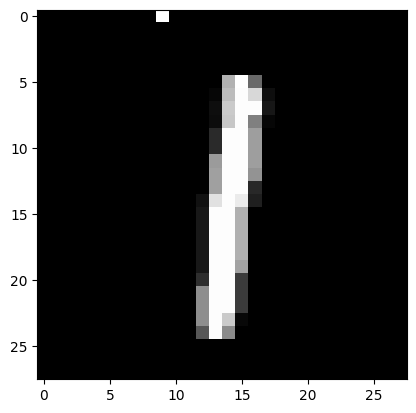

In [13]:
# prediction test & visualization
x,y = train_data[40][0].to(device), train_data[40][1]
data = model.construct_supervised_example(x,y,False)
print("Prediction: ", model.predict(data)," Label: ",y)
plt.imshow(data.squeeze().cpu(), cmap='gray')
plt.show()

In [15]:
# model evaluation using test set
def test():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for x, label in loaders['test']:
            test_output = model.predict(x.to(device))
            correct += (test_output == label)
            total += 1
    print('Test Accuracy of the model on the test set: %.2f' % (correct/total))

## Previous Model Performance

In [19]:
model.load_state_dict(torch.load('model_v1.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [22]:
# adjusted test function (label is messed up when model_v1)
def test_v1():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for x, label in loaders['test']:
            test_output = model.predict(x.to(device)) + 1
            if label == 0:
              test_output -= 5
            correct += (test_output == label)
            total += 1
    print()
    print('Test Accuracy of the model on the test set: %.2f' % (correct/total))
test_v1()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f129f0bc310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test Accuracy of the model on the test set: 0.65
